# DataLoader

For showing and testing DataLoader.py, as well as creating and saving the dataframes containing the training data.

In [1]:
import mne, mne_bids, HelperFunctions, warnings
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from mne_bids import (BIDSPath, read_raw_bids)
from autoreject import AutoReject


def load_raw(data_path, task, preprocessing, subject_id):
    """
    Loads a single subject from the ERP Core data, applies filtering 
    and ICA, downsamples, and returns a mne.Raw object.
    """
    with HelperFunctions.suppress_stdout(), warnings.catch_warnings():
        # ignore warnings, as ERP Core is not quite in BIDS format
        warnings.simplefilter("ignore")
        bids_root = data_path+"/"+"ERP_CORE_BIDS_Raw_Files"
        bids_path = BIDSPath(subject=subject_id, task=task,
                             session=task, datatype='eeg', 
                             suffix='eeg', root=bids_root)
        raw = read_raw_bids(bids_path)
        raw.load_data()
        HelperFunctions.read_annotations_core(bids_path,raw)
        raw.set_channel_types({'HEOG_left': 'eog', 'HEOG_right': 'eog', 'VEOG_lower': 'eog'})
        raw.set_montage('standard_1020',match_case=False)
        raw = raw.resample(250)
        if task == "N170":
             raw = raw.set_eeg_reference(ref_channels='average')
        else: 
            raw = raw.set_eeg_reference(ref_channels=['P9', 'P10'])
        if preprocessing == "medium":
            raw.filter(0.5,40)
        if preprocessing == "heavy":
            raw.filter(0.5,40)
            ica, badComps = HelperFunctions.load_precomputed_ica(bids_root, subject_id,task)
            HelperFunctions.add_ica_info(raw,ica)
            ica.apply(raw)
    return raw

def epoch_raw(raw, task, preprocessing, reject_incorrect_responses=True):
    """
    Takes a mne.Raw object, loads the correct events, 
    and returns a mne.Epoch object.
    """
    with HelperFunctions.suppress_stdout():
        # get correct tmin, tmax, and event mapping per task
        custom_mapping, tmin, tmax = get_task_specifics(task)
        
        # shift annotations by lcd monitor delay
        if task != "MMN":
            raw.annotations.onset = raw.annotations.onset+.026
        
        # load events
        (events_from_annot, event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)
        
        if reject_incorrect_responses == True and task in ["N170", "N400", "N2pc", "P3"]:
        # only include events where response is in time and correct
            events_0, lag_0 = mne.event.define_target_events(events_from_annot, 0, 201, raw.info['sfreq'], 0, 0.8, 0, 999)
            events_1, lag_1 = mne.event.define_target_events(events_from_annot, 1, 201, raw.info['sfreq'], 0, 0.8, 1, 999)
            events_from_annot = np.concatenate((events_0, events_1), axis=0)
            # sort event array by timepoints to get rid of warning
            events_from_annot = events_from_annot[events_from_annot[:, 0].argsort()]
            # drop responses
            event_dict.pop('response:201')
            event_dict.pop('response:202')           

        # epoch with no constant detrend to remove dc offset, pick electrodes
        epoch = mne.Epochs(raw, events_from_annot, event_dict,
                           tmin=tmin,tmax=tmax, preload=True,
                           reject_by_annotation=True, baseline=None, 
                           picks=['FP1','F3','F7','FC3','C3','C5','P3','P7','P9','PO7',
                                  'PO3','O1','Oz','Pz','CPz','FP2','Fz','F4','F8','FC4',
                                  'FCz','Cz','C4','C6','P4','P8','P10','PO8','PO4','O2',], detrend=0)
        
        # apply autoreject for heavy preprocessing to remove artefacts
        if preprocessing == "heavy":
            ar = AutoReject()
            epoch = ar.fit_transform(epoch) 
    return epoch

def get_task_specifics(task, reject_incorrect_responses=True):
    """
    Returns mapping, tmin, tmax, specific to the task.
    """
    tmin = -0.2
    tmax = 0.8
    # mapping is always: 
    # ERP component not expected -> 0
    # ERP component expected -> 1
    # or left -> 0, right -> 1
    if task == "N170":
        # Cars: 0, Faces: 1
        custom_mapping = dict(("stimulus:"+str(i), 1) for i in range(0,41))
        custom_mapping.update(dict(("stimulus:"+str(i), 0) for i in range(41,81)))
    elif task == "N400":
        # unrelated word: 1, Related word: 0
        custom_mapping = {'stimulus:221': 1, 'stimulus:222': 1, 
                          'stimulus:211': 0, 'stimulus:212': 0} 
    elif task == "P3":
        # target=stimulus (rare): 1, target!=stimulus (frequent): 0
        custom_mapping = {'stimulus:11': 1, 'stimulus:12': 0, 'stimulus:13': 0, 'stimulus:14': 0, 'stimulus:15': 0, 
                          'stimulus:21': 0, 'stimulus:22': 1, 'stimulus:23': 0, 'stimulus:24': 0, 'stimulus:25': 0,
                          'stimulus:31': 0, 'stimulus:32': 0, 'stimulus:33': 1, 'stimulus:34': 0, 'stimulus:35': 0,
                          'stimulus:41': 0, 'stimulus:42': 0, 'stimulus:43': 0, 'stimulus:44': 1, 'stimulus:45': 0,
                          'stimulus:51': 0, 'stimulus:52': 0, 'stimulus:53': 0, 'stimulus:54': 0, 'stimulus:55': 1}
    elif task == "N2pc":
        # left: 0, right: 1
        custom_mapping = {'stimulus:111': 0, 'stimulus:112': 0, 'stimulus:211': 0, 'stimulus:212': 0, 
                          'stimulus:121': 1, 'stimulus:122': 1, 'stimulus:221': 1, 'stimulus:222': 1}
    elif task == "MMN":
        # deviant: 1, standard: 0
        custom_mapping = {'stimulus:70': 1, 'stimulus:80': 0}
    elif task == "ERN":
        # incorrect: 1, correct: 0
        custom_mapping = {'response:112': 1, 'response:122': 1, 'response:211': 1, 'response:221': 1,
                          'response:111': 0, 'response:121': 0, 'response:212': 0, 'response:222': 0}
        tmin = -0.6
        tmax = 0.4
    elif task == "LRP":
        # left response: 0, right response: 1
        custom_mapping = {'response:111': 0, 'response:112': 0, 'response:121': 0, 'response:122': 0, 
                          'response:211': 1, 'response:212': 1, 'response:221': 1, 'response:222': 1}
        tmin = -0.8
        tmax = 0.2
    # add button responses to tasks that have them
    if reject_incorrect_responses == True and task in ["N170", "N400", "N2pc", "P3"]:
            custom_mapping.update({'response:201': 201, 'response:202': 202})
    return custom_mapping, tmin, tmax

def create_df(data_path, task, preprocessing, n_subjects=40):
    """
    Creates combined dataframe with epoch, condition, subjectID and data.
    """
    df_list = []
    for i in range(n_subjects):
        subjectID = f"{i+1:03d}"
        raw = load_raw(data_path, task, preprocessing, subjectID)
        epoch = epoch_raw(raw, task, preprocessing)
        df = epoch.to_data_frame()
        df["subjectID"] = i
        df_list.append(df)
    df = pd.concat(df_list, axis=0)
    
    # change condition naming to binary labels
    custom_mapping = get_task_specifics(task)[0]
    for condition in custom_mapping:
        df["condition"] = df["condition"].replace(condition,custom_mapping[condition])
    
    # reshape data
    window_size = 251
    data = df.iloc[:,3:33]
    data = data.to_numpy().reshape(int(data.shape[0]/window_size), window_size, -1)
    data = np.transpose(data,axes=[0,2,1])
    # create labels
    df = df[["epoch","condition","subjectID"]].drop_duplicates()
    df = df.reset_index()
    
    df["data"]=pd.Series(list(data))
    df = df.drop(columns=["index"])
    return df

def save_df(df):
    df.to_pickle(data_path+"/Dataframes/"+task+"_"+preprocessing+".pkl")

def load_df(data_path, task, preprocessing):
    df = pd.read_pickle(data_path+"/Dataframes/"+task+"_"+preprocessing+".pkl")
    return df

def create_data_labels(df, list_of_subjects=None):
    """
    Takes dataframe and returns numpy versions of the data and labels. 
    """
    # get data from dataframe and reshape back
    if list_of_subjects != None:
        df = df[df["subjectID"].isin(list_of_subjects)]
    data = np.dstack(df["data"].to_numpy())
    data = np.moveaxis(data, -1, 0)
    # get labels from dataframe
    labels = df["condition"].to_numpy()
    
    return data, labels

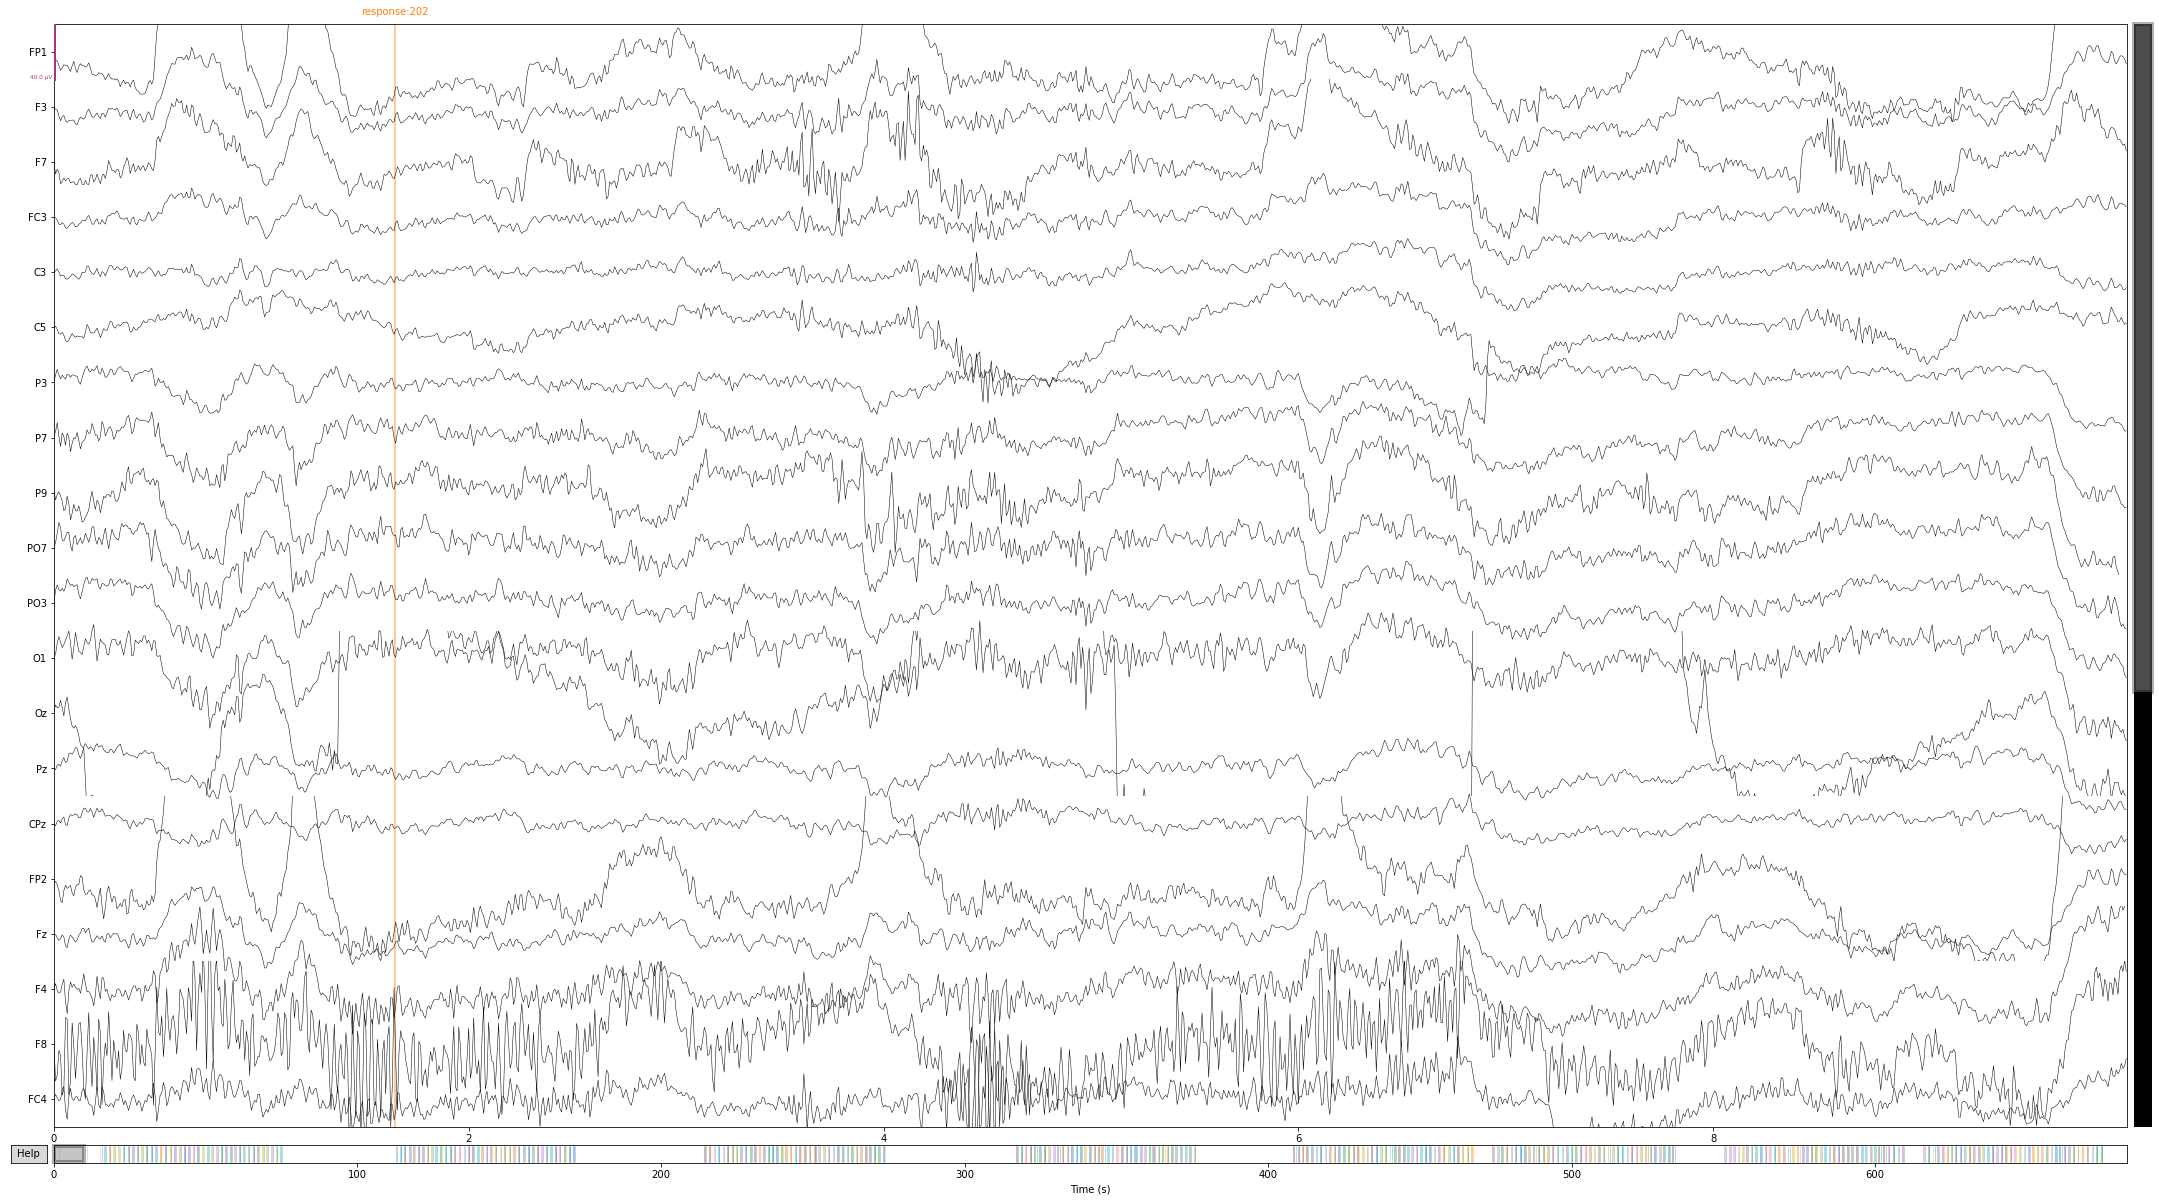

In [3]:
# how to load single subject raw data

# Path of the raw ERP CORE BIDS files
data_path = "F:/Masterthesis/Data/"
task = "N170"
preprocessing = "medium"
raw = load_raw(data_path, task, preprocessing, "001")
raw.plot();

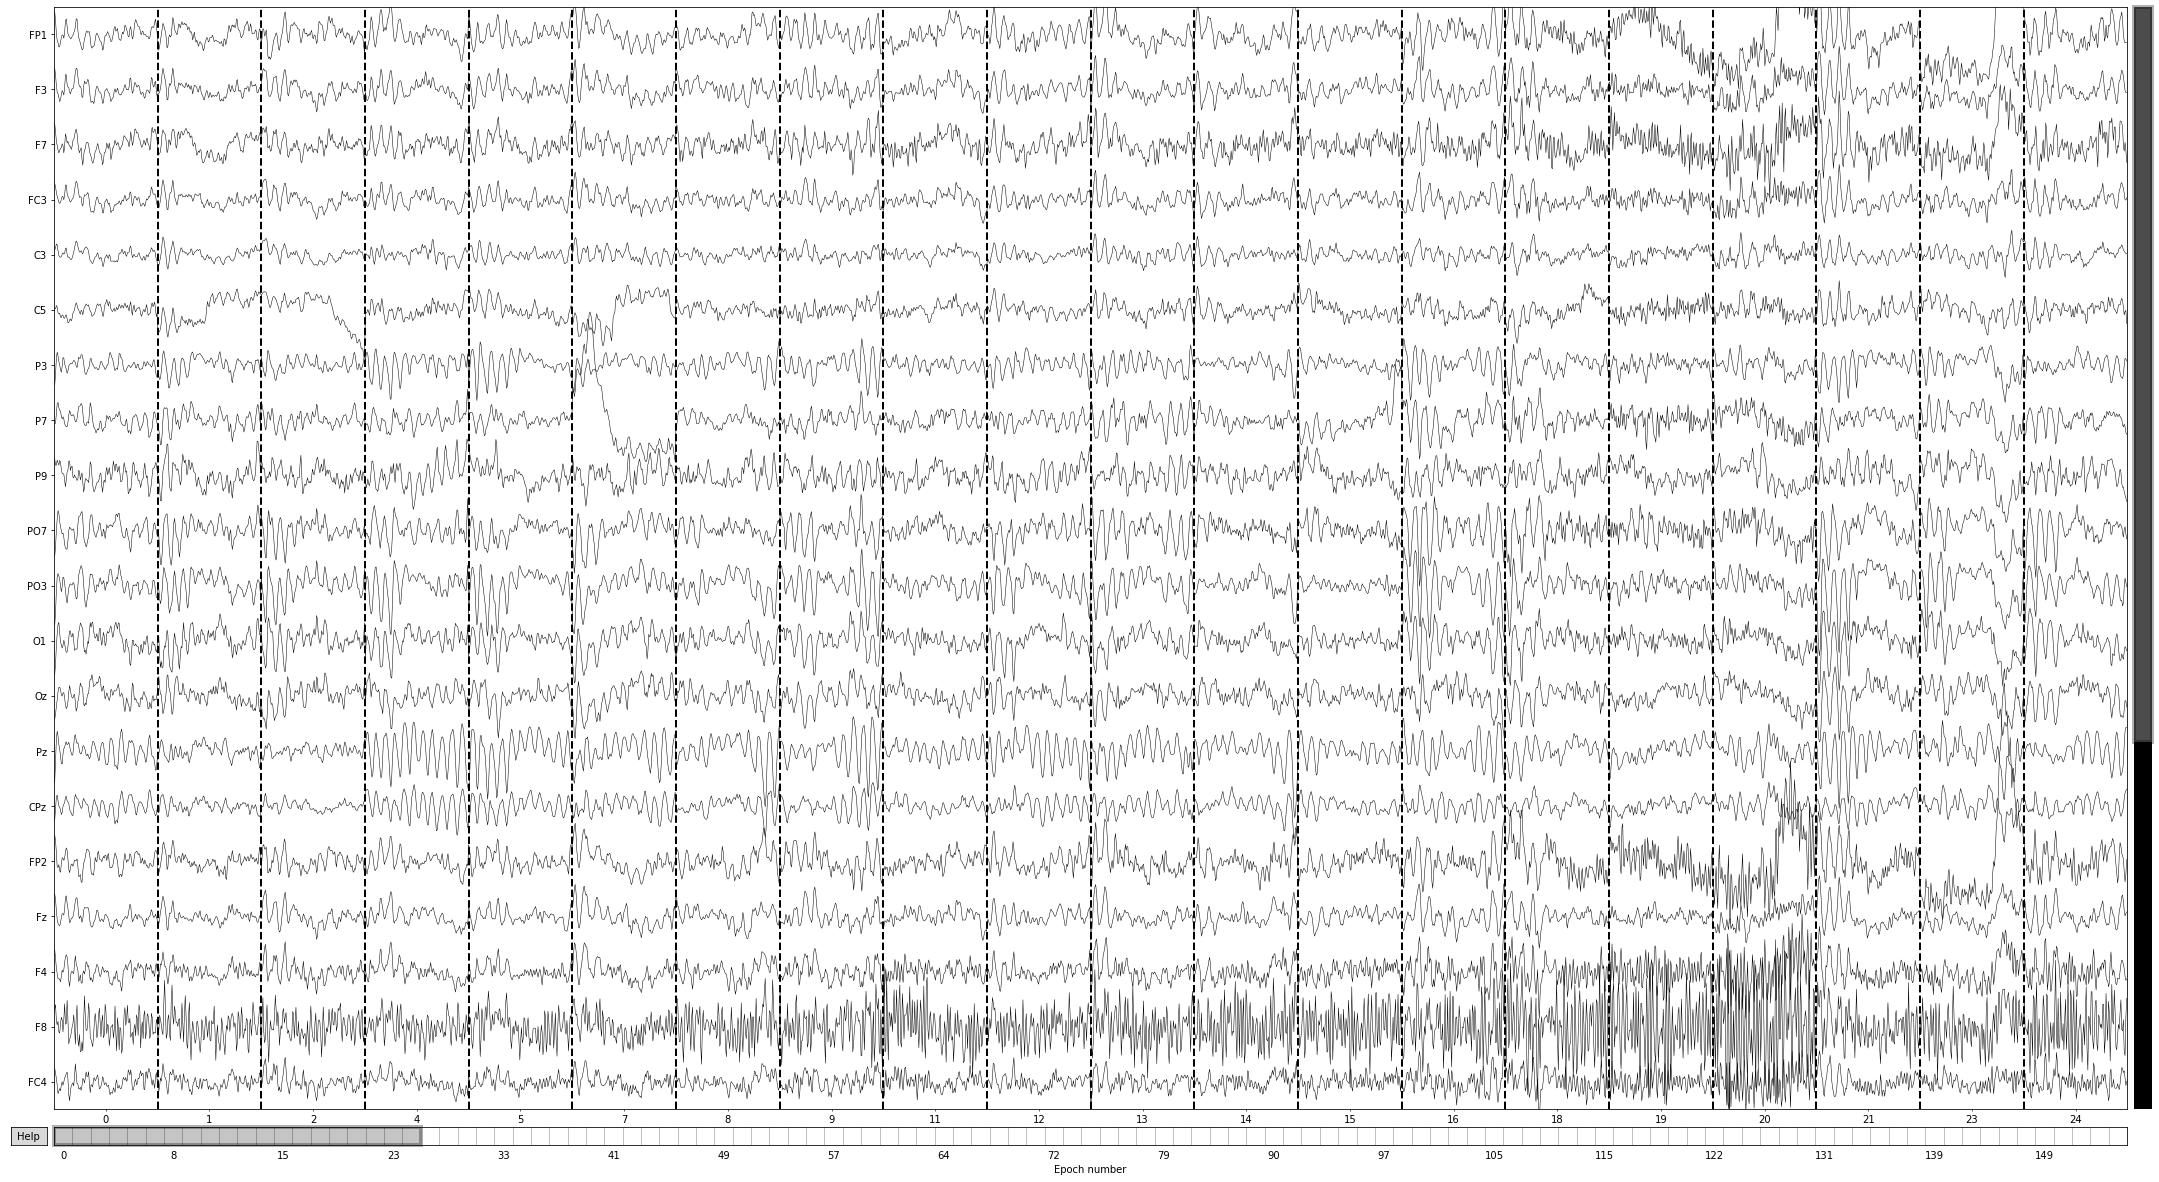

In [4]:
# how to epoch the raw data
epoch = epoch_raw(raw, task, preprocessing)
epoch.plot();

In [7]:
# how to create a dataframe containing epoch, condition, subjectID, and data
df = create_df(data_path, task, preprocessing)
df

epoch  condition  subjectID  \
0         0          0          0   
1         1          0          0   
2         2          0          0   
3         4          1          0   
4         5          1          0   
...     ...        ...        ...   
5776    154          1         39   
5777    155          0         39   
5778    156          1         39   
5779    157          0         39   
5780    159          0         39   

                                                   data  
0     [[17.702971838654694, 17.570405619155203, 16.2...  
1     [[-11.192361616945817, -11.614581130305163, -1...  
2     [[-8.377030045399415, -6.0544504974859095, -2....  
3     [[-3.9305463224822352, -5.271812941070052, -7....  
4     [[14.955650337258403, 13.933921550497315, 11.4...  
...                                                 ...  
5776  [[-16.80749419960997, -21.53557105113876, -24....  
5777  [[-47.46928459229563, -48.33242442368346, -46....  
5778  [[-3.6036698200952912, -7.36822922237286, -11....  
5779  [[-27.961117467514967, -29.35646311075012, -30...  
5780  [[21.461830381816757, 21.15995592015146, 20.47...  

[5781 rows x 4 columns]

## Create and save Dataframes

In [17]:
data_path = "F:/Masterthesis/Data/"
for task in ["N170", "N400", "P3", "MMN", "N2pc", "ERN", "LRP"]:
    for preprocessing in ["light"]:
        df = create_df(data_path, task, preprocessing)
        save_df(df)

In [4]:
data_path = "F:/Masterthesis/Data/"
for task in ["ERN"]:
    for preprocessing in ["heavy"]:
        df = create_df(data_path, task, preprocessing)
        save_df(df)

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.13it/s]


Repairing epochs:   0%|                                                                        | 0/402 [00:00<?, ?it/s]

Repairing epochs:  22%|█████████████▌                                                | 88/402 [00:00<00:00, 873.39it/s]

Repairing epochs:  44%|██████████████████████████▋                                  | 176/402 [00:00<00:00, 863.47it/s]

Repairing epochs:  66%|████████████████████████████████████████                     | 264/402 [00:00<00:00, 868.08it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 872.41it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                        | 0/402 [00:00<?, ?it/s]

Repairing epochs:   6%|███▊    

Repairing epochs:  30%|██████████████████▌                                          | 122/402 [00:00<00:00, 296.94it/s]

Repairing epochs:  38%|███████████████████████▏                                     | 153/402 [00:00<00:00, 298.71it/s]

Repairing epochs:  46%|███████████████████████████▊                                 | 183/402 [00:00<00:00, 290.70it/s]

Repairing epochs:  54%|████████████████████████████████▉                            | 217/402 [00:00<00:00, 305.57it/s]

Repairing epochs:  62%|█████████████████████████████████████▋                       | 248/402 [00:00<00:00, 297.06it/s]

Repairing epochs:  69%|██████████████████████████████████████████▏                  | 278/402 [00:00<00:00, 277.40it/s]

Repairing epochs:  76%|██████████████████████████████████████████████▌              | 307/402 [00:01<00:00, 265.31it/s]

Repairing epochs:  85%|███████████████████████████████████████████████████▋         | 341/402 [00:01<00:00, 282.38it/s]

Repairing epochs:  92%|█████████

Repairing epochs:  66%|████████████████████████████████████████▏                    | 263/399 [00:01<00:00, 235.72it/s]

Repairing epochs:  72%|███████████████████████████████████████████▉                 | 287/399 [00:01<00:00, 224.86it/s]

Repairing epochs:  78%|███████████████████████████████████████████████▍             | 310/399 [00:01<00:00, 221.49it/s]

Repairing epochs:  83%|██████████████████████████████████████████████████▉          | 333/399 [00:01<00:00, 221.56it/s]

Repairing epochs:  89%|██████████████████████████████████████████████████████▍      | 356/399 [00:01<00:00, 219.17it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 232.44it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:01,  4.71it/s]


Fold:  20%|███████████████▍ 

Repairing epochs:  11%|██████▊                                                       | 44/402 [00:00<00:00, 424.21it/s]

Repairing epochs:  22%|█████████████▍                                                | 87/402 [00:00<00:00, 394.02it/s]

Repairing epochs:  32%|███████████████████▎                                         | 127/402 [00:00<00:00, 304.87it/s]

Repairing epochs:  41%|████████████████████████▉                                    | 164/402 [00:00<00:00, 325.08it/s]

Repairing epochs:  50%|██████████████████████████████▏                              | 199/402 [00:00<00:00, 325.74it/s]

Repairing epochs:  58%|███████████████████████████████████▎                         | 233/402 [00:00<00:00, 329.39it/s]

Repairing epochs:  68%|█████████████████████████████████████████▍                   | 273/402 [00:00<00:00, 348.98it/s]

Repairing epochs:  77%|██████████████████████████████████████████████▉              | 309/402 [00:00<00:00, 340.28it/s]

Repairing epochs:  86%|█████████

Repairing epochs:   5%|███▎                                                          | 21/387 [00:00<00:01, 208.43it/s]

Repairing epochs:  12%|███████▎                                                      | 46/387 [00:00<00:01, 231.81it/s]

Repairing epochs:  19%|████████████                                                  | 75/387 [00:00<00:01, 255.08it/s]

Repairing epochs:  26%|████████████████                                             | 102/387 [00:00<00:01, 256.13it/s]

Repairing epochs:  36%|█████████████████████▊                                       | 138/387 [00:00<00:00, 291.15it/s]

Repairing epochs:  43%|██████████████████████████▍                                  | 168/387 [00:00<00:00, 290.65it/s]

Repairing epochs:  51%|███████████████████████████████▏                             | 198/387 [00:00<00:00, 279.73it/s]

Repairing epochs:  59%|███████████████████████████████████▊                         | 227/387 [00:00<00:00, 272.13it/s]

Repairing epochs:  67%|█████████

Repairing epochs:  58%|███████████████████████████████████▋                         | 235/402 [00:00<00:00, 243.46it/s]

Repairing epochs:  65%|███████████████████████████████████████▌                     | 261/402 [00:01<00:00, 247.84it/s]

Repairing epochs:  71%|███████████████████████████████████████████▍                 | 286/402 [00:01<00:00, 245.05it/s]

Repairing epochs:  77%|███████████████████████████████████████████████▏             | 311/402 [00:01<00:00, 238.26it/s]

Repairing epochs:  85%|███████████████████████████████████████████████████▌         | 340/402 [00:01<00:00, 252.74it/s]

Repairing epochs:  91%|███████████████████████████████████████████████████████▌     | 366/402 [00:01<00:00, 251.37it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 402/402 [00:01<00:00, 246.02it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋          

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 403/403 [00:01<00:00, 305.36it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00, 39.71it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.78it/s]

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.03s/it]


Repairing epochs:   0%|                                                                        | 0/403 [00:00<?, ?it/s]

Repairing epochs:   7%|████▌                                                         | 30/403 [00:00<00:01, 291.97it/s]

Repairing epochs:  15%|█████████▏                                                    | 60/403 [00:00<00:01, 270.40it/s]

Repairing epochs:  23%|████

Repairing epochs:  72%|███████████████████████████████████████████▋                 | 289/403 [00:01<00:00, 199.91it/s]

Repairing epochs:  77%|██████████████████████████████████████████████▉              | 310/403 [00:01<00:00, 196.71it/s]

Repairing epochs:  82%|██████████████████████████████████████████████████▎          | 332/403 [00:01<00:00, 201.25it/s]

Repairing epochs:  88%|█████████████████████████████████████████████████████▋       | 355/403 [00:01<00:00, 208.52it/s]

Repairing epochs:  94%|█████████████████████████████████████████████████████████▏   | 378/403 [00:01<00:00, 213.09it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.11it/s]


Repairing epochs:   0%|                                                                        | 0/401 [00:00<?, ?it/s]

Repairing epochs:  21%|████████████▉                                                 | 84/401 [00:00<00:00, 833.91it/s]

Repairing epochs:  42%|████████

Repairing epochs:  75%|█████████████████████████████████████████████▊               | 302/402 [00:01<00:00, 228.25it/s]

Repairing epochs:  81%|█████████████████████████████████████████████████▎           | 325/402 [00:01<00:00, 222.22it/s]

Repairing epochs:  87%|████████████████████████████████████████████████████▊        | 348/402 [00:01<00:00, 220.25it/s]

Repairing epochs:  92%|████████████████████████████████████████████████████████▎    | 371/402 [00:01<00:00, 221.30it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 402/402 [00:01<00:00, 237.59it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:02,  4.32it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:01,  4.31it/s]


Fold:  30%|████████████████

Repairing epochs:  64%|███████████████████████████████████████▏                     | 258/402 [00:01<00:00, 267.20it/s]

Repairing epochs:  72%|███████████████████████████████████████████▋                 | 288/402 [00:01<00:00, 276.42it/s]

Repairing epochs:  79%|████████████████████████████████████████████████▎            | 318/402 [00:01<00:00, 280.38it/s]

Repairing epochs:  86%|████████████████████████████████████████████████████▋        | 347/402 [00:01<00:00, 276.87it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 402/402 [00:01<00:00, 258.18it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:02,  4.42it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:01,  4.42it/s]


Fold:  30%|████████████████

Repairing epochs:   9%|█████▌                                                        | 36/401 [00:00<00:01, 343.69it/s]

Repairing epochs:  18%|██████████▉                                                   | 71/401 [00:00<00:01, 299.57it/s]

Repairing epochs:  25%|███████████████▌                                             | 102/401 [00:00<00:01, 275.62it/s]

Repairing epochs:  34%|████████████████████▉                                        | 138/401 [00:00<00:00, 304.71it/s]

Repairing epochs:  42%|█████████████████████████▋                                   | 169/401 [00:00<00:00, 302.72it/s]

Repairing epochs:  50%|██████████████████████████████▍                              | 200/401 [00:00<00:00, 291.36it/s]

Repairing epochs:  57%|██████████████████████████████████▉                          | 230/401 [00:00<00:00, 275.02it/s]

Repairing epochs:  65%|███████████████████████████████████████▍                     | 259/401 [00:00<00:00, 277.19it/s]

Repairing epochs:  72%|█████████

Repairing epochs:  76%|██████████████████████████████████████████████▏              | 304/402 [00:01<00:00, 287.35it/s]

Repairing epochs:  83%|██████████████████████████████████████████████████▌          | 333/402 [00:01<00:00, 286.42it/s]

Repairing epochs:  90%|██████████████████████████████████████████████████████▉      | 362/402 [00:01<00:00, 283.50it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 402/402 [00:01<00:00, 275.11it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:02,  4.20it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:01,  4.14it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:01,  4.14it/s]


Fold:  40%|███████████████

Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:01<00:00,  4.45it/s]


Fold:  70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:01<00:00,  4.45it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:01<00:00,  4.19it/s]


Fold:  90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [00:02<00:00,  4.17it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.32it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:07<00:03,  3.83s/it]

Repairing epochs:   0%|                                                                        | 0/403 [00:00<?, ?it/s]

Repairing epochs:   6%|████                                                          | 26/403 [00:00<00:01, 246.00it/s]

Repairing epochs:  13%|█████

Repairing epochs:  82%|██████████████████████████████████████████████████▏          | 331/402 [00:01<00:00, 321.18it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.05it/s]


Repairing epochs:   0%|                                                                        | 0/403 [00:00<?, ?it/s]

Repairing epochs:  22%|█████████████▍                                                | 87/403 [00:00<00:00, 859.39it/s]

Repairing epochs:  43%|██████████████████████████▏                                  | 173/403 [00:00<00:00, 854.88it/s]

Repairing epochs:  64%|███████████████████████████████████████▏                     | 259/403 [00:00<00:00, 817.57it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 403/403 [00:00<00:00, 828.40it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|        

Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.93it/s]

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:04<00:08,  4.03s/it]

Repairing epochs:   0%|                                                                        | 0/402 [00:00<?, ?it/s]

Repairing epochs:   7%|████▎                                                         | 28/402 [00:00<00:01, 269.95it/s]

Repairing epochs:  15%|█████████▍                                                    | 61/402 [00:00<00:01, 303.45it/s]

Repairing epochs:  23%|██████████████▏                                               | 92/402 [00:00<00:01, 294.78it/s]

Repairing epochs:  30%|██████████████████▌                                          | 122/402 [00:00<00:00, 290.45it/s]

Repairing epochs:  38%|███████████████████████▎                                     | 154/402 [00:00<00:00, 299.96it/s]

Repairing epochs:  46%|█████████

Repairing epochs:  30%|██████████████████                                           | 119/402 [00:00<00:01, 239.04it/s]

Repairing epochs:  36%|█████████████████████▋                                       | 143/402 [00:00<00:01, 238.80it/s]

Repairing epochs:  42%|█████████████████████████▊                                   | 170/402 [00:00<00:00, 244.32it/s]

Repairing epochs:  49%|██████████████████████████████                               | 198/402 [00:00<00:00, 254.84it/s]

Repairing epochs:  56%|█████████████████████████████████▉                           | 224/402 [00:00<00:00, 249.74it/s]

Repairing epochs:  62%|█████████████████████████████████████▉                       | 250/402 [00:01<00:00, 239.50it/s]

Repairing epochs:  68%|█████████████████████████████████████████▋                   | 275/402 [00:01<00:00, 235.27it/s]

Repairing epochs:  75%|█████████████████████████████████████████████▉               | 303/402 [00:01<00:00, 246.10it/s]

Repairing epochs:  83%|█████████

Repairing epochs:   0%|                                                                        | 0/403 [00:00<?, ?it/s]

Repairing epochs:  22%|█████████████▌                                                | 88/403 [00:00<00:00, 865.05it/s]

Repairing epochs:  43%|██████████████████████████▍                                  | 175/403 [00:00<00:00, 835.07it/s]

Repairing epochs:  65%|███████████████████████████████████████▋                     | 262/403 [00:00<00:00, 847.96it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 403/403 [00:00<00:00, 857.87it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                        | 0/403 [00:00<?, ?it/s]

Repairing epochs:  12%|███████▍                                                      | 48/403 [00:00<00:00, 458.25it/s]

Repairing epochs:  23%|█████████

Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:02,  4.34it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:01,  4.37it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:01,  4.38it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:01,  4.35it/s]


Fold:  50%|██████████████████████████████████████▌                                      | 5/10 [00:01<00:01,  4.33it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:01<00:00,  4.35it/s]


Fold:  70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:01<00:00,  4.37it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:01<00:00,  4.40it/s]


Fold:  90%|█████████████

Repairing epochs:  90%|██████████████████████████████████████████████████████▋      | 360/402 [00:01<00:00, 278.83it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 30/30 [00:25<00:00,  1.17it/s]


Repairing epochs:   0%|                                                                        | 0/402 [00:00<?, ?it/s]

Repairing epochs:  22%|█████████████▋                                                | 89/402 [00:00<00:00, 883.54it/s]

Repairing epochs:  44%|███████████████████████████                                  | 178/402 [00:00<00:00, 880.17it/s]

Repairing epochs:  67%|████████████████████████████████████████▋                    | 268/402 [00:00<00:00, 886.11it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 402/402 [00:00<00:00, 884.55it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|        

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:03<00:07,  3.57s/it]

Repairing epochs:   0%|                                                                        | 0/402 [00:00<?, ?it/s]

Repairing epochs:  12%|███████▏                                                      | 47/402 [00:00<00:00, 466.48it/s]

Repairing epochs:  23%|██████████████▍                                               | 94/402 [00:00<00:00, 376.50it/s]

Repairing epochs:  34%|████████████████████▋                                        | 136/402 [00:00<00:00, 385.15it/s]

Repairing epochs:  44%|██████████████████████████▋                                  | 176/402 [00:00<00:00, 381.28it/s]

Repairing epochs:  54%|████████████████████████████████▊                            | 216/402 [00:00<00:00, 385.34it/s]

Repairing epochs:  63%|██████████████████████████████████████▋                      | 255/402 [00:00<00:00, 346.69it/s]

Repairing epochs:  74%|█████████

Fold:  50%|██████████████████████████████████████▌                                      | 5/10 [00:00<00:00, 40.76it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.37it/s]

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.22s/it]


Repairing epochs:   0%|                                                                        | 0/402 [00:00<?, ?it/s]

Repairing epochs:   8%|████▉                                                         | 32/402 [00:00<00:01, 314.57it/s]

Repairing epochs:  16%|█████████▊                                                    | 64/402 [00:00<00:01, 290.06it/s]

Repairing epochs:  23%|██████████████▍                                               | 94/402 [00:00<00:01, 272.39it/s]

Repairing epochs:  31%|██████████████████▊                                          | 124/402 [00:00<00:01, 277.66it/s]

Repairing epochs:  38%|███████

Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:02,  4.18it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:01,  4.12it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:01,  4.15it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:01,  4.18it/s]


Fold:  50%|██████████████████████████████████████▌                                      | 5/10 [00:01<00:01,  4.20it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:01<00:00,  4.15it/s]


Fold:  70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:01<00:00,  4.17it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:01<00:00,  4.13it/s]


Fold:  90%|█████████████

Fold:  50%|██████████████████████████████████████▌                                      | 5/10 [00:01<00:01,  4.48it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:01<00:00,  4.45it/s]


Fold:  70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:01<00:00,  4.43it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:01<00:00,  4.38it/s]


Fold:  90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [00:02<00:00,  4.38it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.41it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:07<00:03,  3.70s/it]

Repairing epochs:   0%|                                                                        | 0/402 [00:00<?, ?it/s]

Repairing epochs:   8%|████

Repairing epochs:  59%|████████████████████████████████████                         | 238/402 [00:00<00:00, 248.00it/s]

Repairing epochs:  65%|███████████████████████████████████████▉                     | 263/402 [00:01<00:00, 241.17it/s]

Repairing epochs:  73%|████████████████████████████████████████████▎                | 292/402 [00:01<00:00, 251.70it/s]

Repairing epochs:  79%|████████████████████████████████████████████████▍            | 319/402 [00:01<00:00, 254.77it/s]

Repairing epochs:  86%|████████████████████████████████████████████████████▎        | 345/402 [00:01<00:00, 247.21it/s]

Repairing epochs:  92%|████████████████████████████████████████████████████████▏    | 370/402 [00:01<00:00, 246.12it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 30/30 [00:26<00:00,  1.13it/s]


Repairing epochs:   0%|                                                                        | 0/402 [00:00<?, ?it/s]

Repairing epochs:  22%|████████

Repairing epochs:  11%|██████▊                                                       | 44/401 [00:00<00:01, 209.36it/s]

Repairing epochs:  17%|██████████▎                                                   | 67/401 [00:00<00:01, 216.87it/s]

Repairing epochs:  22%|█████████████▊                                                | 89/401 [00:00<00:01, 210.15it/s]

Repairing epochs:  28%|█████████████████▏                                           | 113/401 [00:00<00:01, 217.70it/s]

Repairing epochs:  35%|█████████████████████▎                                       | 140/401 [00:00<00:01, 231.33it/s]

Repairing epochs:  41%|████████████████████████▉                                    | 164/401 [00:00<00:01, 231.57it/s]

Repairing epochs:  47%|████████████████████████████▌                                | 188/401 [00:00<00:00, 218.67it/s]

Repairing epochs:  53%|████████████████████████████████▏                            | 212/401 [00:00<00:00, 224.42it/s]

Repairing epochs:  59%|█████████

Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:01,  4.53it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:01,  4.53it/s]


Fold:  50%|██████████████████████████████████████▌                                      | 5/10 [00:01<00:01,  4.55it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:01<00:00,  4.58it/s]


Fold:  70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:01<00:00,  4.60it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:01<00:00,  4.60it/s]


Fold:  90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [00:01<00:00,  4.57it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.57it/s]

n_interp:  67%|██████████

Repairing epochs:  26%|███████████████▊                                             | 104/401 [00:00<00:00, 337.28it/s]

Repairing epochs:  34%|████████████████████▉                                        | 138/401 [00:00<00:00, 313.35it/s]

Repairing epochs:  44%|██████████████████████████▊                                  | 176/401 [00:00<00:00, 332.80it/s]

Repairing epochs:  54%|████████████████████████████████▋                            | 215/401 [00:00<00:00, 349.06it/s]

Repairing epochs:  63%|██████████████████████████████████████▏                      | 251/401 [00:00<00:00, 322.39it/s]

Repairing epochs:  71%|███████████████████████████████████████████▏                 | 284/401 [00:00<00:00, 305.85it/s]

Repairing epochs:  79%|███████████████████████████████████████████████▉             | 315/401 [00:00<00:00, 302.15it/s]

Repairing epochs:  86%|████████████████████████████████████████████████████▋        | 346/401 [00:01<00:00, 302.52it/s]

Computing thresholds ...: 100%|█

Repairing epochs:  84%|███████████████████████████████████████████████████▏         | 337/402 [00:01<00:00, 312.33it/s]

Repairing epochs:  92%|███████████████████████████████████████████████████████▉     | 369/402 [00:01<00:00, 299.93it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 402/402 [00:01<00:00, 289.79it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:02,  4.18it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:01,  4.15it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:01,  4.02it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:01,  3.96it/s]


Fold:  50%|██████████████

Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:01,  4.58it/s]


Fold:  50%|██████████████████████████████████████▌                                      | 5/10 [00:01<00:01,  4.53it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:01<00:00,  4.48it/s]


Fold:  70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:01<00:00,  4.50it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:01<00:00,  4.53it/s]


Fold:  90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [00:01<00:00,  4.52it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.52it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:08<00:04,  4.02s/it]

Repairing epochs:   0%|   

Repairing epochs:  86%|████████████████████████████████████████████████████▋        | 346/401 [00:01<00:00, 234.50it/s]

Repairing epochs:  92%|████████████████████████████████████████████████████████▎    | 370/401 [00:01<00:00, 231.59it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 401/401 [00:01<00:00, 221.17it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  50%|██████████████████████████████████████▌                                      | 5/10 [00:00<00:00, 40.76it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 40.59it/s]

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.54s/it]


Repairing epochs:   0%|                                                                        | 0/401 [00:00<?, ?it/s]

Repairing epochs:   5%|███ 

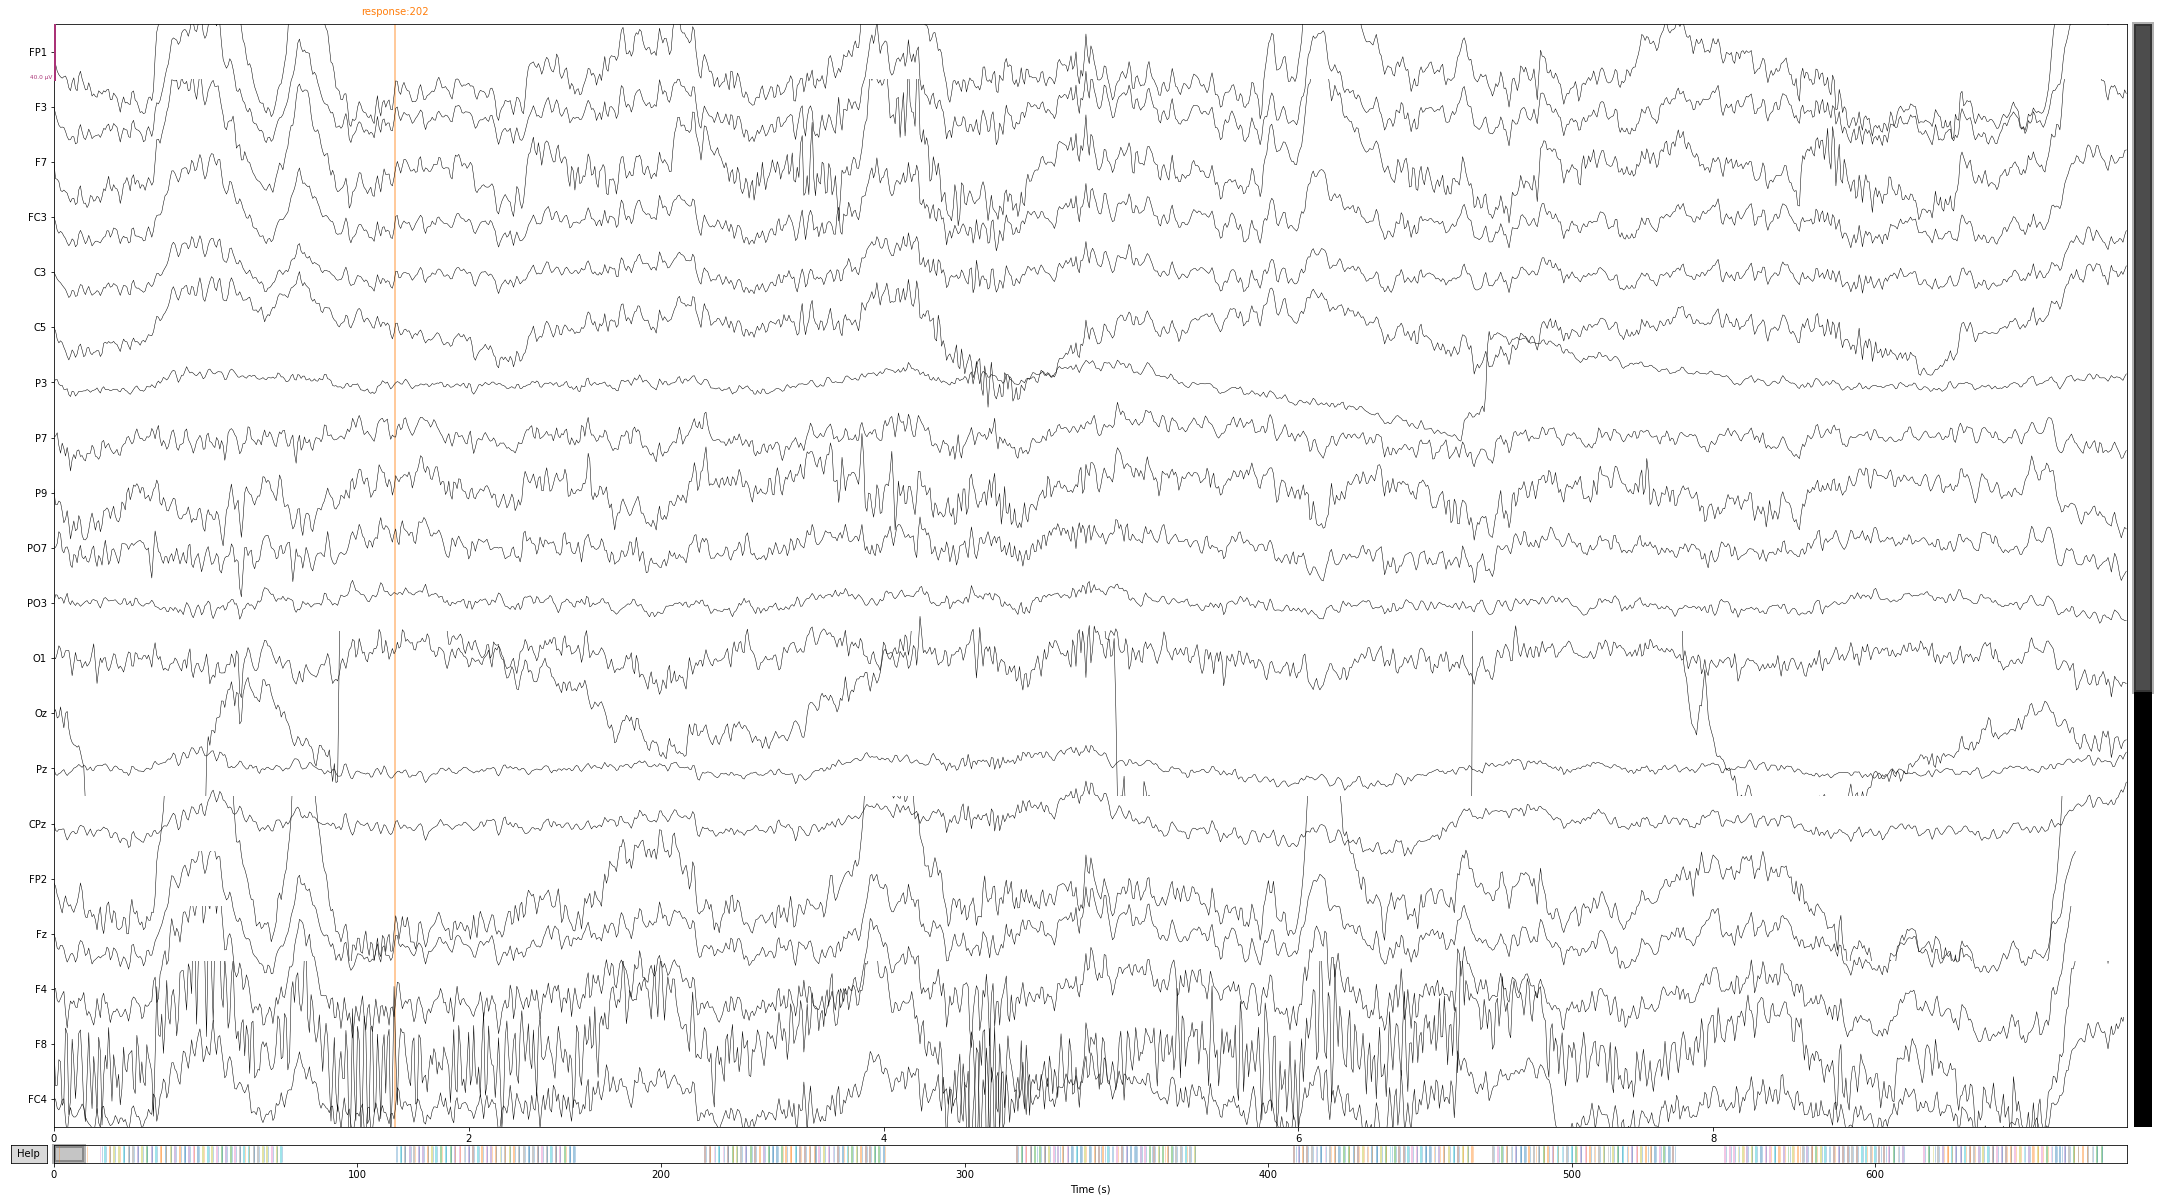

In [2]:
data_path = "F:/Masterthesis/Data/"
task = "N170"
preprocessing = "medium"
raw = load_raw(data_path, task, preprocessing, "001")
raw.plot();

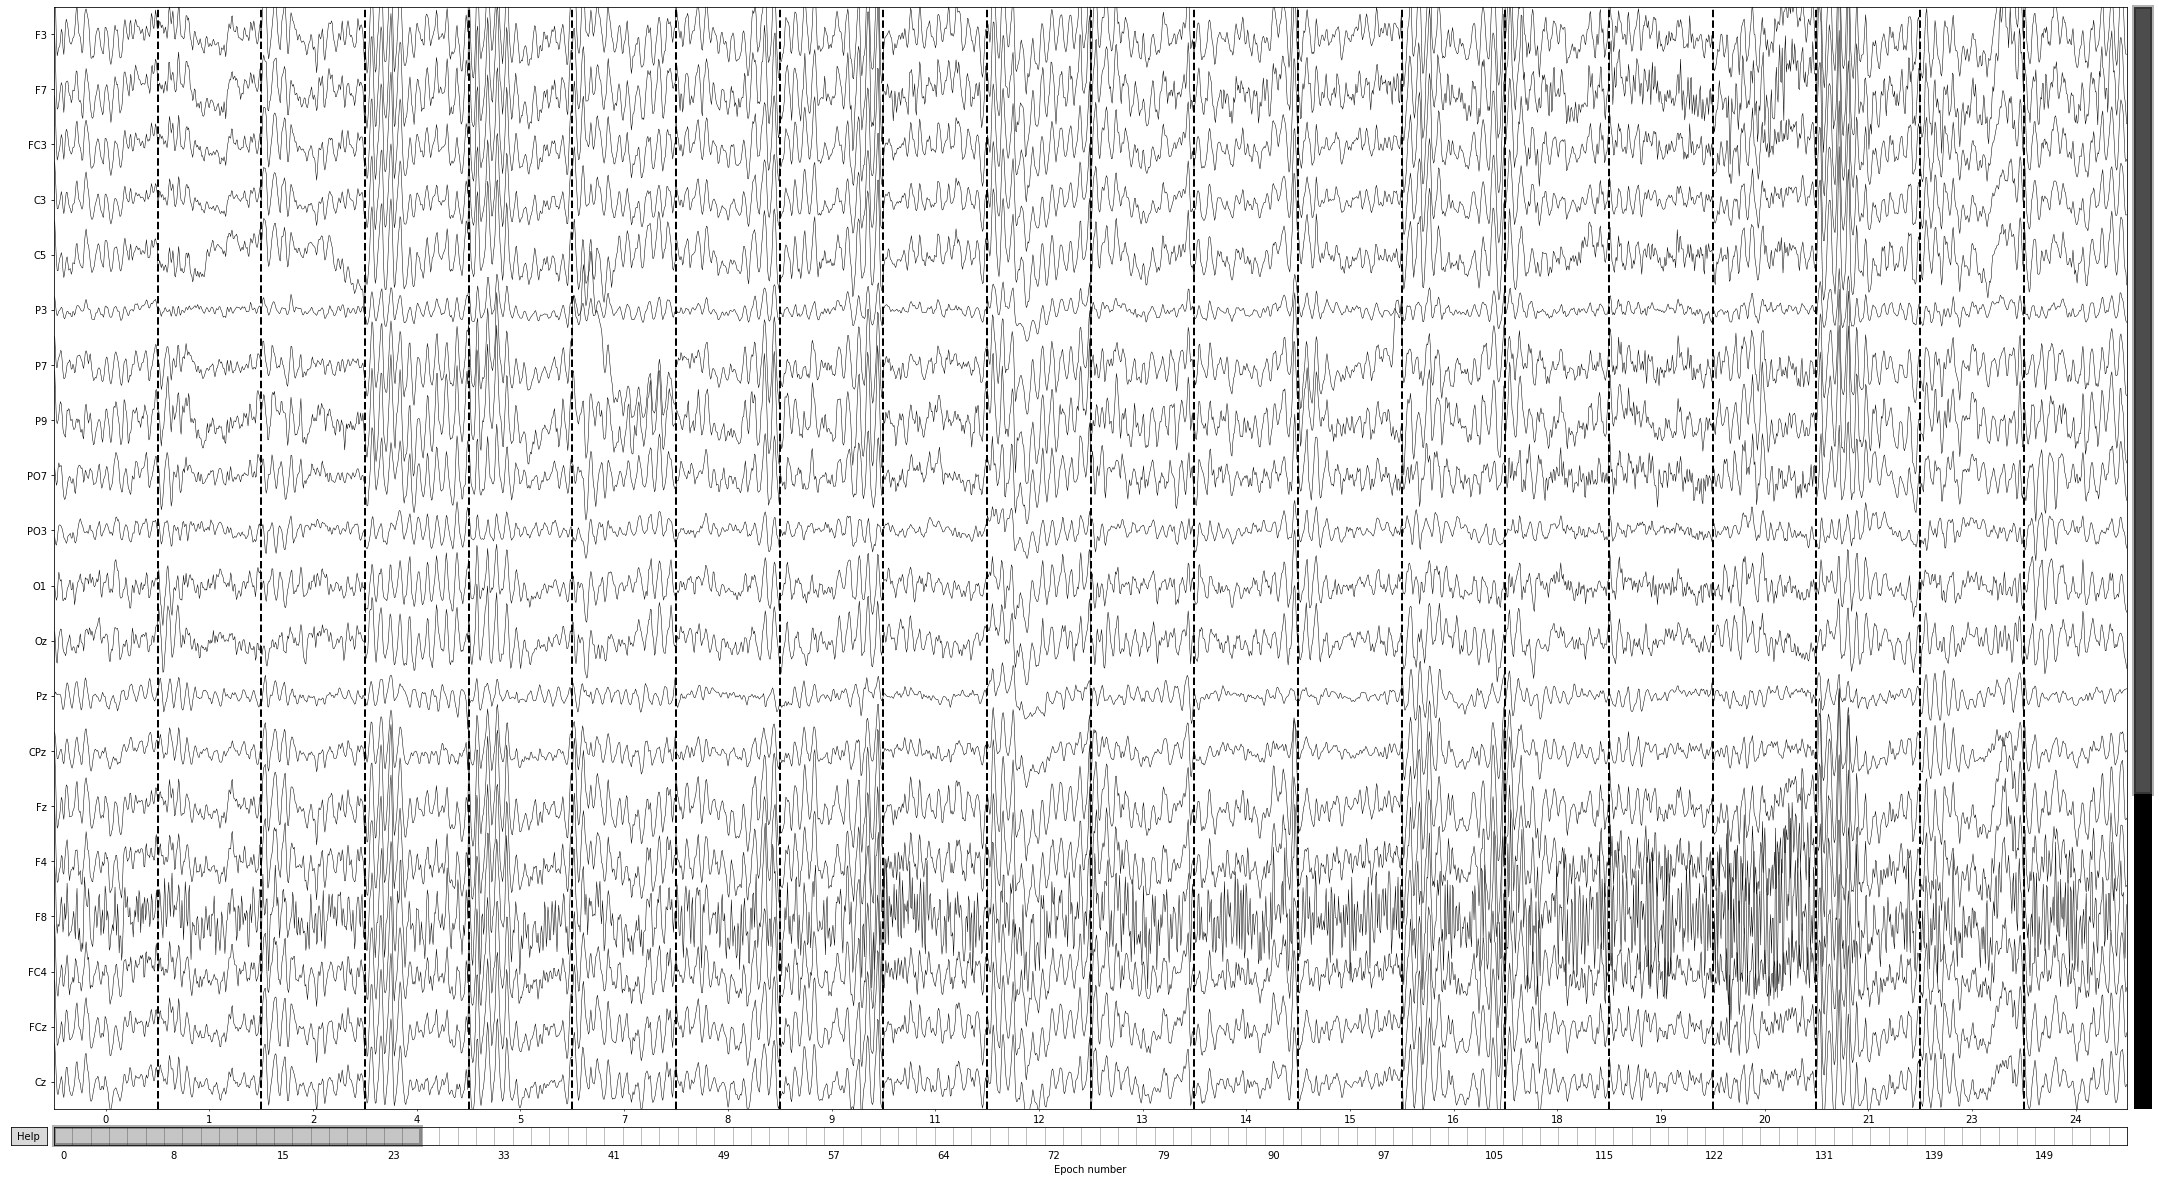

In [3]:
epoch = epoch_raw(raw, task, preprocessing)
epoch.plot();

In [4]:
epoch.to_data_frame()

time    condition  epoch         F3         F7        FC3         C3  \
0      -200  stimulus:80      0  41.230274  39.455302  37.443511  30.171315   
1      -196  stimulus:80      0  41.765078  41.078659  37.807969  29.739263   
2      -192  stimulus:80      0  38.928924  38.640814  35.305908  27.136245   
3      -188  stimulus:80      0  31.756590  31.048024  29.037811  22.160212   
4      -184  stimulus:80      0  20.590919  19.313531  19.353421  15.271862   
...     ...          ...    ...        ...        ...        ...        ...   
28358   784   stimulus:9    159 -12.436854   8.844345  -7.480625  -2.025711   
28359   788   stimulus:9    159  -9.896740  16.493311  -9.300265  -2.775377   
28360   792   stimulus:9    159  -6.637538  20.990838  -8.149276  -2.377389   
28361   796   stimulus:9    159  -4.185487  18.536479  -3.752709  -0.375884   
28362   800   stimulus:9    159  -2.741872   9.412510   1.697919   2.043205   

              C5         P3         P7  ...        FCz         Cz         C4  \
0      28.678196  11.343655  25.753059  ...  35.298572  28.094044  20.185882   
1      27.782135  10.865929  25.010023  ...  36.205036  29.227339  25.595153   
2      24.400614   9.209314  20.910184  ...  33.922191  27.743180  27.843103   
3      18.534540   6.623358  14.700092  ...  27.969614  23.340856  25.482006   
4      10.925500   3.534306   7.954095  ...  18.870523  16.649090  18.832586   
...          ...        ...        ...  ...        ...        ...        ...   
28358   1.872556  -4.303633   5.167847  ...  -5.969317  -2.909292  -4.399428   
28359   1.244656  -4.543293   3.271964  ...  -8.824204  -4.522199  -6.797162   
28360   3.834604  -4.229885  -0.050146  ... -10.550606  -5.875580  -8.210547   
28361   8.398271  -3.500159  -2.575591  ... -10.632213  -6.799504  -8.651814   
28362  10.650453  -2.775884  -2.714236  ...  -9.486099  -7.155202  -8.153411   

              C6         P4         P8        P10        PO8       PO4  \
0      29.204492   2.807449  28.846849  39.480821  17.184737 -1.988505   
1      37.392506   8.611623  31.195741  40.324096  18.803238  2.810143   
2      36.104565  13.122558  27.044298  35.163040  14.610848  5.818724   
3      26.571292  13.227795  16.122047  24.118181   3.759793  4.613823   
4      14.829980   7.933556   1.249579   9.754981 -11.505088 -1.303580   
...          ...        ...        ...        ...        ...       ...   
28358  -6.786098  -2.399779  -2.881660   0.442795  -0.848005 -0.452226   
28359  -8.610579  -4.141213  -3.143846  -0.698186  -2.825334 -2.139033   
28360 -11.000933  -4.681279  -1.301379   0.058215  -2.445587 -2.272341   
28361 -11.615238  -3.863038   2.163700   2.989414   0.294024 -0.429651   
28362  -8.255513  -2.188710   5.777842   7.039396   4.054461  2.270677   

             O2  
0      7.412761  
1      9.024114  
2      7.470873  
3      2.499741  
4     -4.994170  
...         ...  
28358  2.809504  
28359  2.507016  
28360  2.594300  
28361  3.153663  
28362  4.035198  

[28363 rows x 31 columns]

In [7]:
df = load_df(data_path, task, preprocessing)

In [16]:
df["data"].shape

epoch  condition  subjectID  \
0         0          0          0   
1         1          0          0   
2         2          0          0   
3         4          1          0   
4         5          1          0   
...     ...        ...        ...   
5776    154          1         39   
5777    155          0         39   
5778    156          1         39   
5779    157          0         39   
5780    159          0         39   

                                                   data  
0     [[41.23027354522549, 41.76507820944795, 38.928...  
1     [[1.9524139500691624, 3.7566056980455445, 4.69...  
2     [[-3.0399094019800486, 2.3797442472317196, 9.6...  
3     [[-4.60570607906713, -9.745721803170467, -15.1...  
4     [[42.81865940169189, 36.85808844487722, 27.594...  
...                                                 ...  
5776  [[-3.7487470514909713, -8.081862739628036, -9....  
5777  [[-15.285657236963576, -18.274890462977787, -1...  
5778  [[35.73841564706618, 28.06711892997384, 20.267...  
5779  [[-25.679635212812062, -25.217531937162754, -2...  
5780  [[15.12122360343841, 15.123550994001787, 13.46...  

[5781 rows x 4 columns]

In [22]:
df[df["subjectID"]==0]["data"][112][0]

array([-1.13956992e+01, -1.16933949e+01, -7.25362387e+00, -4.83700583e-01,
        4.57960778e+00,  5.78060576e+00,  4.62168675e+00,  4.50578990e+00,
        7.13738640e+00,  1.07818419e+01,  1.21742301e+01,  1.00483165e+01,
        6.57531150e+00,  5.05895063e+00,  6.46857258e+00,  8.33250767e+00,
        7.12755515e+00,  1.64238325e+00, -5.99293541e+00, -1.21914570e+01,
       -1.44853835e+01, -1.24166014e+01, -6.69044615e+00,  1.63487677e+00,
        1.08487226e+01,  1.81485607e+01,  2.05482563e+01,  1.70081837e+01,
        9.82629705e+00,  3.52109704e+00,  1.79020935e+00,  5.09513707e+00,
        1.07185912e+01,  1.50103703e+01,  1.56445902e+01,  1.25594032e+01,
        7.45037536e+00,  2.59297433e+00, -3.99436592e-01, -1.43951979e+00,
       -1.97919421e+00, -3.74254621e+00, -6.90239895e+00, -9.34012809e+00,
       -8.17197327e+00, -2.48067834e+00,  5.40491532e+00,  1.15645209e+01,
        1.36720451e+01,  1.25795369e+01,  1.07713343e+01,  9.50173770e+00,
        7.80851232e+00,  

In [15]:
data_path = "F:/Masterthesis/Data/"
preprocessing = "medium"
for task in ["N170", "N400", "P3", "MMN", "N2pc", "ERN", "LRP"]:
    df = load_df(data_path, task, preprocessing)
    print(task)
    print(df[df["condition"]==0].count()[0])
    print(df[df["condition"]==1].count()[0])

N170
2860
2921
N400
1894
1549
P3
6186
1338
MMN
31265
7967
N2pc
5370
5456
ERN
14230
1818
LRP
7951
8097


In [13]:
df[df["condition"]==1].count()[0]

2921